In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [6]:
!kaggle datasets download -d hasyimabdillah/workoutexercises-images

Dataset URL: https://www.kaggle.com/datasets/hasyimabdillah/workoutexercises-images
License(s): CC-BY-NC-SA-4.0
100% 815M/818M [00:36<00:00, 24.5MB/s]
100% 818M/818M [00:37<00:00, 23.2MB/s]


In [7]:
!unzip workoutexercises-images.zip -d workout-exercises-images

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: workout-exercises-images/pull up/pull up_700211.jpg  
  inflating: workout-exercises-images/pull up/pull up_700221.jpg  
  inflating: workout-exercises-images/pull up/pull up_700231.jpg  
  inflating: workout-exercises-images/pull up/pull up_700241.jpg  
  inflating: workout-exercises-images/pull up/pull up_700251.jpg  
  inflating: workout-exercises-images/pull up/pull up_700261.jpg  
  inflating: workout-exercises-images/pull up/pull up_800001.jpg  
  inflating: workout-exercises-images/pull up/pull up_800011.jpg  
  inflating: workout-exercises-images/pull up/pull up_800021.jpg  
  inflating: workout-exercises-images/pull up/pull up_800031.jpg  
  inflating: workout-exercises-images/pull up/pull up_800041.jpg  
  inflating: workout-exercises-images/pull up/pull up_800051.jpg  
  inflating: workout-exercises-images/pull up/pull up_800061.jpg  
  inflating: workout-exercises-images/pull up/pull up_800071.jpg  
  inflating: wo

In [8]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3

In [9]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 256
img_shape = (height, width, channels)
img_size = (height, width)

In [10]:
DATA_DIR = '/content/workout-exercises-images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = False,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


In [11]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomBrightness(0.1),
                                         tf.keras.layers.RandomZoom(0.1)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

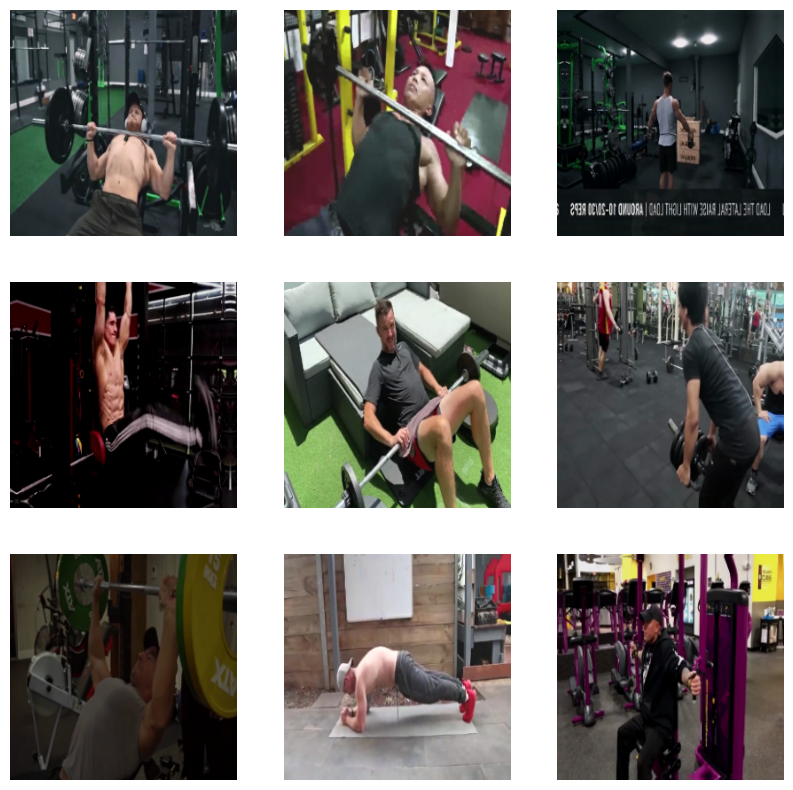

In [12]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

In [13]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [14]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.BatchNormalization()(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input,
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [15]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss',
                                        patience = 5,
                                        mode = 'auto',
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100,
                            callbacks = [early_stopping_callback]
                           )

Epoch 1/100
49/49 [==============================] - 114s 2s/step - loss: 2.3135 - accuracy: 0.3325 - val_loss: 1.9899 - val_accuracy: 0.5552
Epoch 2/100
49/49 [==============================] - 92s 2s/step - loss: 1.5470 - accuracy: 0.5545 - val_loss: 1.4866 - val_accuracy: 0.6426
Epoch 3/100
49/49 [==============================] - 92s 2s/step - loss: 1.1631 - accuracy: 0.6643 - val_loss: 1.3469 - val_accuracy: 0.6274
Epoch 4/100
49/49 [==============================] - 92s 2s/step - loss: 0.9617 - accuracy: 0.7203 - val_loss: 0.8989 - val_accuracy: 0.7487
Epoch 5/100
49/49 [==============================] - 92s 2s/step - loss: 0.8015 - accuracy: 0.7676 - val_loss: 0.5545 - val_accuracy: 0.8513
Epoch 6/100
49/49 [==============================] - 92s 2s/step - loss: 0.7318 - accuracy: 0.7904 - val_loss: 0.6308 - val_accuracy: 0.8159
Epoch 7/100
49/49 [==============================] - 92s 2s/step - loss: 0.6582 - accuracy: 0.8091 - val_loss: 0.5582 - val_accuracy: 0.8520
Epoch 8/100


6/6 [==============================] - 1s 122ms/step - loss: 0.1229 - accuracy: 0.9690


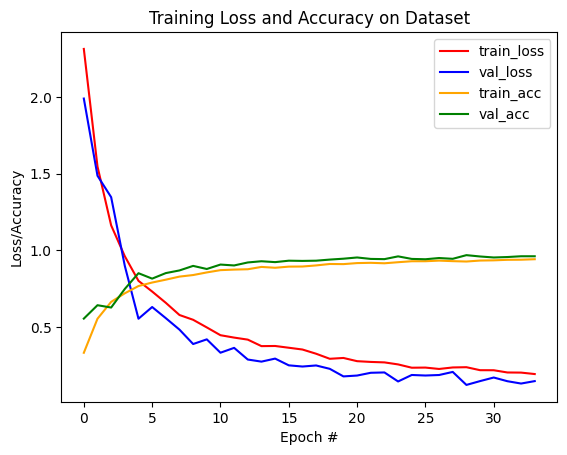

In [16]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [17]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [18]:
current_datetime = datetime.now()

# Save Model
workout_model.save(f'workout_model_{current_datetime}')

# Save .h5 model
workout_model.save(f'workout_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./workout_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'workout_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
